(reglin_2_notebook)=
# Regressione lineare bivariata

In questo capitolo, verrà trattato il modello di regressione bivariata, il quale utilizza una relazione lineare per predire una variabile continua $y$ a partire da un solo predittore continuo $x$. In altre parole, il modello si adatta ai dati ($x_i, y_i$) attraverso la retta di regressione $y_i = a + bx_i + e_i$, con $i=1, \dots, n$. Verrà illustrato come stimare i coefficienti di regressione $a$ e $b$ utilizzando dei dati reali, e come tali coefficienti possono essere interpretati. Inoltre, verrà descritta la valutazione della bontà di adattamento del modello ai dati.

In [3]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import statistics
import statsmodels.api as sm
from scipy import optimize
import warnings

warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")


In [4]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
# Initialize random number generator
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
sns.set(color_codes=True)
az.style.use("arviz-darkgrid")
sns.set_theme(
    context="paper",
    palette="colorblind",
)


In questo esempio, esamineremo i dati `kidiq` {cite}`gelman2020regression`, che consistono in una raccolta di dati provenienti da una survey su donne adulte americane e i loro figli, selezionati da un sotto-campione del National Longitudinal Survey of Youth. 

Nello specifico, ci concentreremo sulla relazione tra il punteggio di intelligenza del bambino (`kid_score`) e quello della madre (`mom_iq`). Ci proponiamo di valutare se e in quale misura l'intelligenza della madre possa prevedere l'intelligenza del bambino. Per fare ciò, inizieremo leggendo i dati.

In [5]:
kidiq = pd.read_stata("data/kidiq.dta")
kidiq.head() 


,kid_score,mom_hs,mom_iq,mom_work,mom_age
0,65,1.0,121.117529,4,27
1,98,1.0,89.361882,4,25
2,85,1.0,115.443165,4,27
3,83,1.0,99.449639,3,25
4,115,1.0,92.745710,4,27


Un diagramma a dispersione per i dati di questo campione suggerisce la presenza di un'associazione positiva tra l'intelligenza del bambino (`kid_score`) e l'intelligenza della madre (`mom_iq`).

Text(0, 0.5, 'QI del bambino')

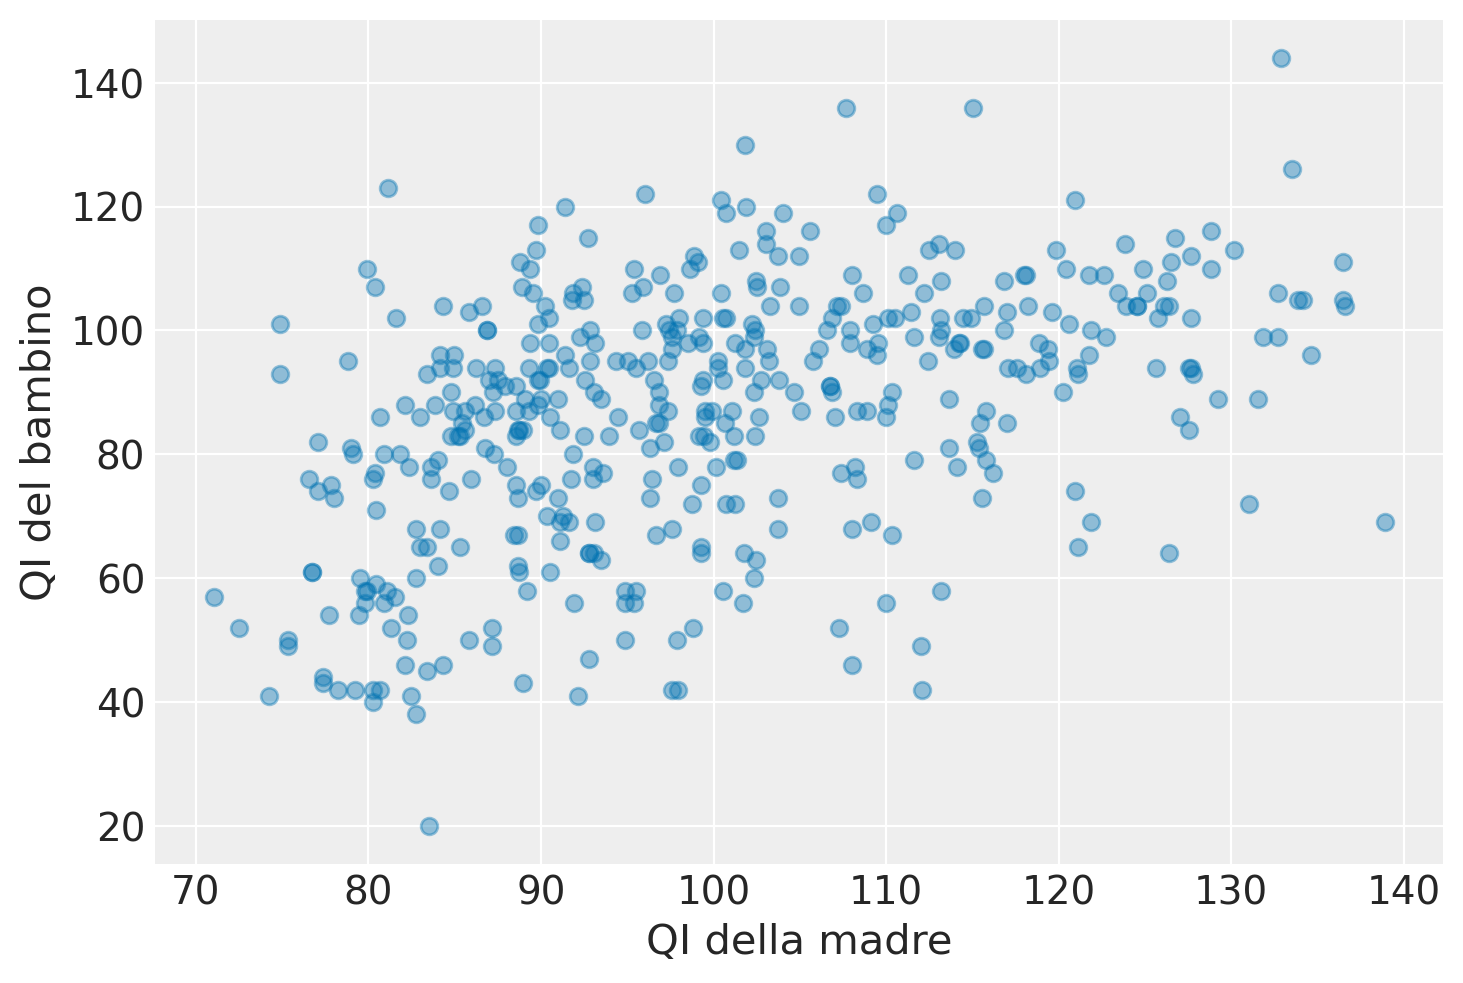

In [6]:
_, ax = plt.subplots()
ax.plot(kidiq["mom_iq"], kidiq["kid_score"], "o", alpha=0.4)
ax.set_xlabel("QI della madre")
ax.set_ylabel("QI del bambino")


Il modello di regressione lineare descrive questa associazione mediante una retta.

Text(0, 0.5, 'QI del bambino')

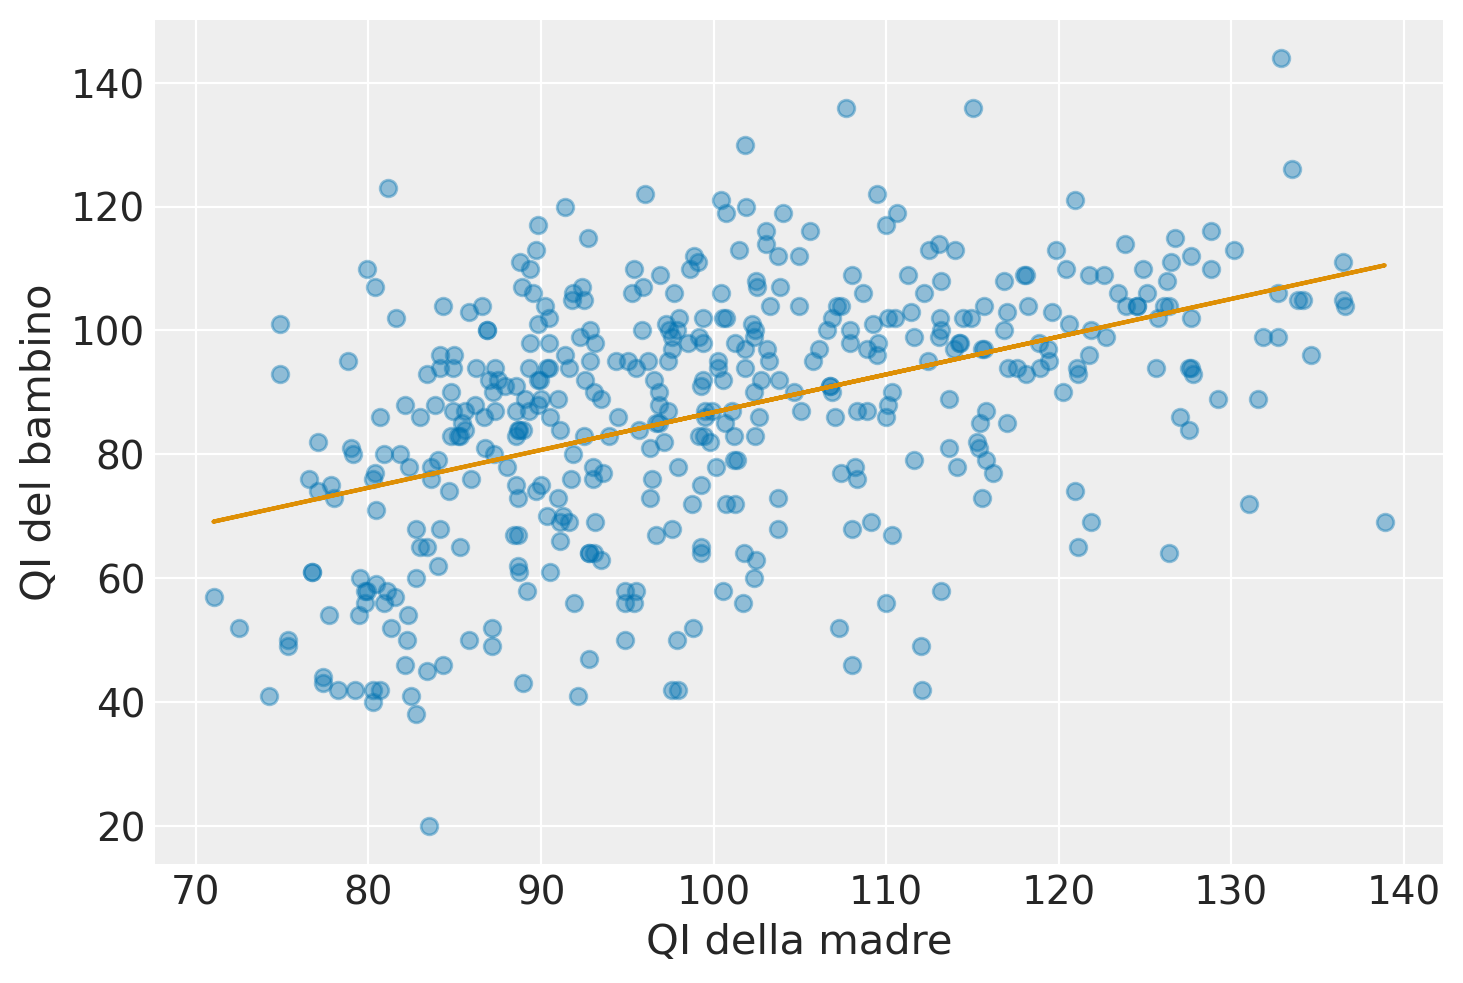

In [7]:
_, ax = plt.subplots()
ax.plot(kidiq["mom_iq"], kidiq["kid_score"], "o", alpha=0.4)
# obtain m (slope) and b(intercept) of linear regression line
b, a = np.polyfit(kidiq["mom_iq"], kidiq["kid_score"], 1)
# add linear regression line to scatterplot
plt.plot(kidiq["mom_iq"], a + b * kidiq["mom_iq"])
ax.set_xlabel("QI della madre")
ax.set_ylabel("QI del bambino")


Ci sono però infinite rette che, in linea di principio, possono essere usate per "approssimare" la nube di punti nel diagramma a dispersione. È dunque necessario introdurre dei vincoli per selezionare una di queste possibili rette. Il vincolo che viene introdotto dal modello di regressione è quello di costringere la retta a passare per il punto $(\bar{x}, \bar{y})$.

Text(0, 0.5, 'QI del bambino')

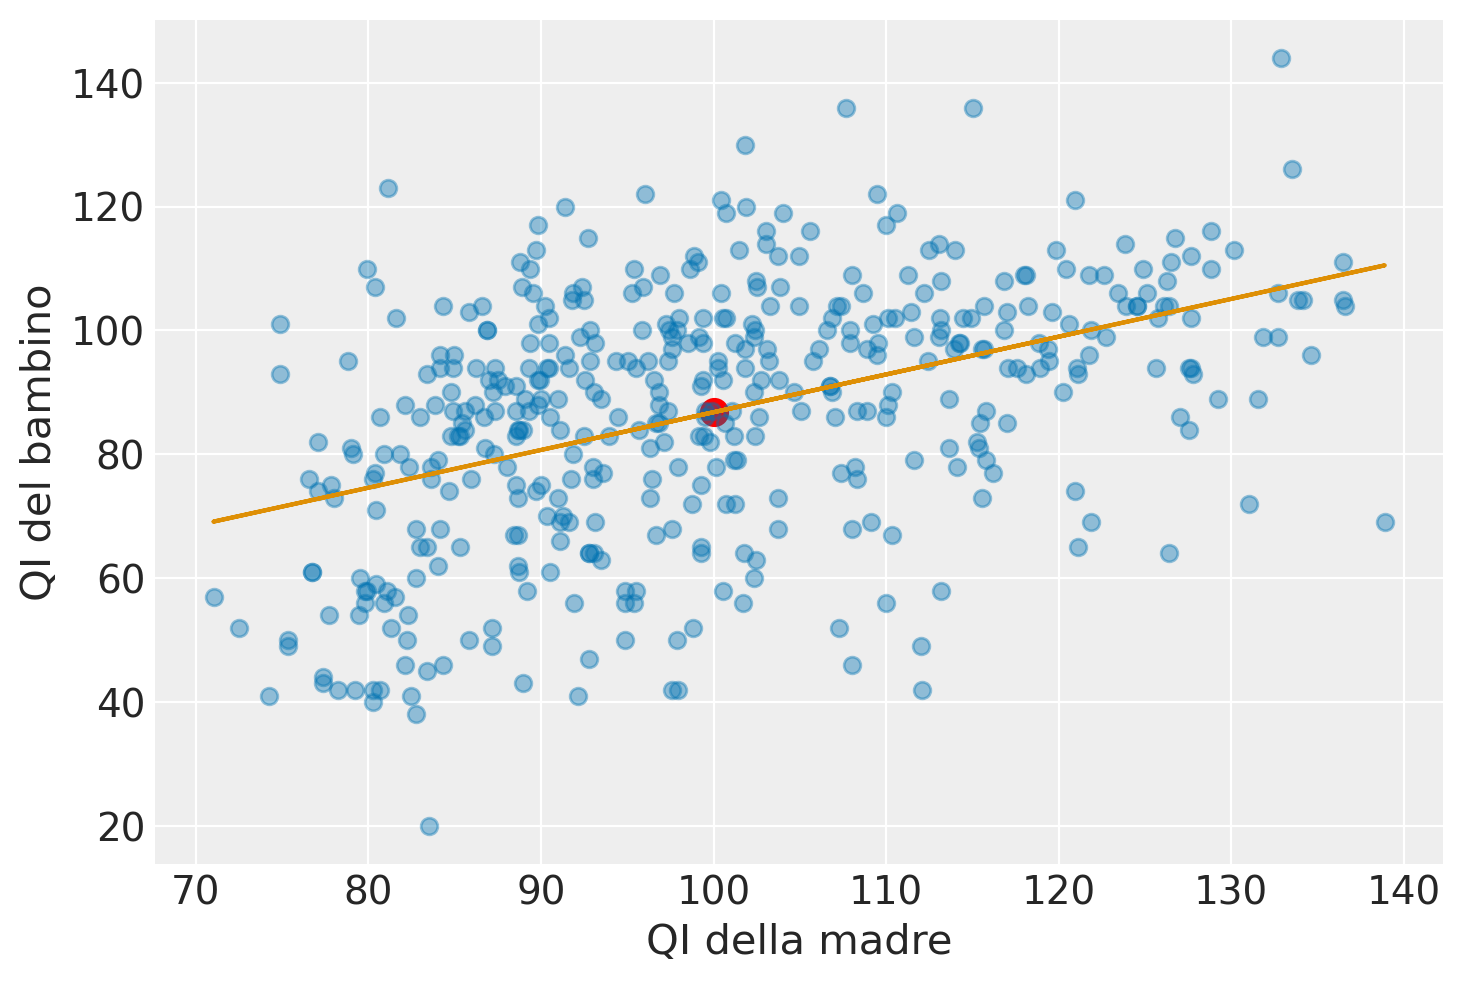

In [8]:
_, ax = plt.subplots()
ax.plot(kidiq["mom_iq"], kidiq["kid_score"], "o", alpha=0.4)
# obtain m (slope) and b(intercept) of linear regression line
b, a = np.polyfit(kidiq["mom_iq"], kidiq["kid_score"], 1)
# add linear regression line to scatterplot
plt.plot(kidiq["mom_iq"], a + b * kidiq["mom_iq"])
plt.scatter([np.mean(kidiq.mom_iq)], [np.mean(kidiq.kid_score)], s=90, c="r")
ax.set_xlabel("QI della madre")
ax.set_ylabel("QI del bambino")


Una retta di regressione che passa per il punto medio $(\bar{x}, \bar{y})$ (che rappresenta il centro di massa dei dati) è preferibile dal punto di vista statistico poiché minimizza la somma dei quadrati degli errori residui.

Il campione è costituito da $n$ coppie di osservazioni ($x, y$). Per ciascuna coppia di valori $x_i, y_i$, il modello di regressione si aspetta che il valore $y_i$ sia associato al corrispondente valore $x_i$ come indicato dalla seguente equazione:

$$
\begin{equation}
\mathbb{E}(y_i) = a + b x_i .
\end{equation}
$$

I valori $y_i$ corrispondono, nell'esempio che stiamo discutendo, alla variabile `kid_score`. I primi 10 valori della variabile $y$ sono i seguenti:

In [9]:
kidiq["kid_score"][0:10]


0     65
1     98
2     85
3     83
4    115
5     98
6     69
7    106
8    102
9     95
Name: kid_score, dtype: int32

Per fare riferimento a ciascuna osservazione usiamo l'indice $i$. Quindi, ad esempio, $y_3$ è uguale a

In [10]:
print(kidiq["kid_score"][2])


85


Il modello di regressione lineare bivariata, rappresentato dall'equazione $y_i = a + b x_i + e_i$, descrive la relazione tra le variabili $x$ e $y$, dove $y$ è la variabile dipendente (nel nostro esempio, la variabile `kid_score`) e $x$ è la variabile indipendente (nel nostro esempio, la variabile `mom_iq`). Il valore di $y$ è la somma di due componenti: la componente deterministica, $\hat{y}$, e la componente aleatoria, $e_i$. La componente deterministica rappresenta la porzione della $y$ che è prevedibile conoscendo il valore di $x$, mentre la componente aleatoria rappresenta la porzione della $y$ che non è prevedibile dal modello.

Il modello lineare cerca di trovare i coefficienti $a$ e $b$ che permettono di prevedere la componente deterministica di $y$ conoscendo il valore di $x$. Tuttavia, poiché la retta è solo un'approssimazione della relazione tra $x$ e $y$, la componente deterministica rappresenta solo una stima approssimata della vera relazione tra le due variabili.

Per valutare l'accuratezza del modello di regressione lineare, è necessario calcolare il residuo, ovvero la differenza tra il valore osservato di $y$ e il valore previsto dal modello, $\hat{y}$. La dimensione del residuo indica quanto la componente aleatoria contribuisce al valore osservato di $y$.

Il modello di regressione lineare ha tre obiettivi: il primo è quello di trovare i coefficienti $a$ e $b$ che permettono di prevedere la componente deterministica di $y$ conoscendo il valore di $x$. Il secondo obiettivo è quello di valutare l'accuratezza della predizione fornita dal modello di regressione lineare. Infine, il terzo obiettivo è quello dell'inferenza, ovvero quello di capire quali relazioni esistono tra la relazione tra $x$ e $y$ osservata nel campione e la relazione tra le due variabili nella popolazione.

## Stima dei coefficienti di regressione

In breve, stiamo cercando di trovare una relazione tra due variabili, il QI della madre e il QI del bambino, utilizzando un modello di regressione lineare. L'equazione lineare che descrive la relazione tra le due variabili è della forma $\hat{y}_i = a_i + bx_i$, dove $\hat{y}_i$ rappresenta la previsione per il QI del bambino $i$-esimo, $a_i$ e $b$ sono i coefficienti di regressione che vogliamo trovare e $x_i$ è il QI della madre del bambino $i$-esimo.

Per trovare i coefficienti di regressione, dobbiamo introdurre dei vincoli per limitare lo spazio delle possibili soluzioni. Il primo vincolo è che la retta di regressione deve passare per il baricentro del grafico a dispersione. Il secondo vincolo è che vogliamo minimizzare la somma dei quadrati dei residui, ovvero la differenza tra il valore osservato e il valore previsto dal modello. I coefficienti di regressione che soddisfano questi vincoli si chiamano coefficienti dei minimi quadrati.


Il problema di trovare i coefficienti di regressione $a$ e $b$ che minimizzano la somma dei quadrati dei residui ha una soluzione analitica. Questa soluzione si ottiene trovando il punto di minimo di una superficie tridimensionale che rappresenta la somma dei quadrati dei residui. Il punto di minimo è quello per cui il piano tangente alla superficie nelle due direzioni $a$ e $b$ è piatto, cioè le derivate parziali rispetto ad $a$ e $b$ sono uguali a zero. In pratica, ciò significa risolvere un sistema di equazioni lineari con due incognite $a$ e $b$, noto come equazioni normali.

La soluzione delle equazioni normali ci fornisce i coefficienti di regressione stimati, che minimizzano la somma dei quadrati dei residui.  La formula per il coefficiente $a$ è

$$
a = \bar{y} - b \bar{x}.
$$

La formula per il coefficiente $b$ è

$$
b = \frac{Cov(x, y)}{Var(x)},
$$

dove $\bar{x}$ e $\bar{y}$ sono le medie delle variabili $x$ e $y$, $Cov(x,y)$ è la covarianza tra $x$ e $y$ e $Var(x)$ è la varianza di $x$.

Queste equazioni rappresentano la stima dei minimi quadrati dei coefficienti di regressione che ci permettono di trovare la retta che minimizza la somma dei quadrati dei residui.

Nel caso dell'esempio presente, tali coefficienti sono uguali a:

In [11]:
cov_xy = np.cov(kidiq["kid_score"], kidiq["mom_iq"], ddof=1)[0][1]
var_x = np.var(kidiq["mom_iq"], ddof=1)
b = cov_xy / var_x
b


0.609974571730785

In [12]:
a = np.mean(kidiq["kid_score"]) - b * np.mean(kidiq["mom_iq"])
a


25.799777849962986

Verifichiamo i risultati trovati usando funzione `optimize.curve_fit`. Questa è una funzione molto potente, in quanto può adattarsi non solo alle funzioni lineari, ma anche alle funzioni non lineari. Qui la usiamo per la retta di regressione.

In [13]:
def func(x, a, b):
    y = a + b*x
    return y
  
optimize.curve_fit(func, xdata = kidiq.mom_iq, ydata = kidiq.kid_score)[0]

array([25.7997779 ,  0.60997457])

### Interpretazione

Il coefficiente $a$ indica l'intercetta della retta di regressione nel diagramma a dispersione. Questo valore rappresenta il punto in cui la retta di regressione interseca l'asse $y$ del sistema di assi cartesiani. Tuttavia, in questo caso specifico, il valore di $a$ non è di particolare interesse poiché corrisponde al valore della retta di regressione quando l'intelligenza della madre è pari a 0, il che non ha senso nella situazione reale. Successivamente, vedremo come è possibile trasformare i dati per fornire un'interpretazione utile del coefficiente $a$.

Invece, il coefficiente $b$ indica la pendenza della retta di regressione, ovvero di quanto aumenta (se $b$ è positivo) o diminuisce (se $b$ è negativo) la retta di regressione in corrispondenza di un aumento di 1 punto della variabile $x$. Nel caso specifico del QI delle madri e dei loro figli, il coefficiente $b$ ci indica che un aumento di 1 punto del QI delle madri è associato, in media, a un aumento di 0.61 punti del QI dei loro figli.

In pratica, il modello di regressione lineare cerca di prevedere le medie dei punteggi del QI dei figli in base al QI delle madri. Ciò significa che non è in grado di prevedere esattamente il punteggio di ciascun bambino in funzione del QI della madre, ma solo una stima della media dei punteggi dei figli quando il QI delle madri aumenta o diminuisce di un punto.

Il coefficiente $b$ ci dice di quanto aumenta (o diminuisce) in media il QI dei figli per ogni unità di aumento (o diminuzione) del QI della madre. Nel nostro caso, se il QI della madre aumenta di un punto, il QI dei figli aumenta in media di 0.61 punti.

È importante comprendere che il modello statistico di regressione lineare non è in grado di prevedere il valore preciso di ogni singolo bambino, ma solo una stima della media dei punteggi del QI dei figli quando il QI delle madri aumenta o diminuisce. Questa stima è basata su una distribuzione di valori possibili che si chiama distribuzione condizionata $p(y \mid x_i)$.

Una rappresentazione grafica del valore predetto dal modello di regressione, $\hat{y}_i = a + bx_i$, per tutte le osservazioni del campione è fornito dalla figura seguente.

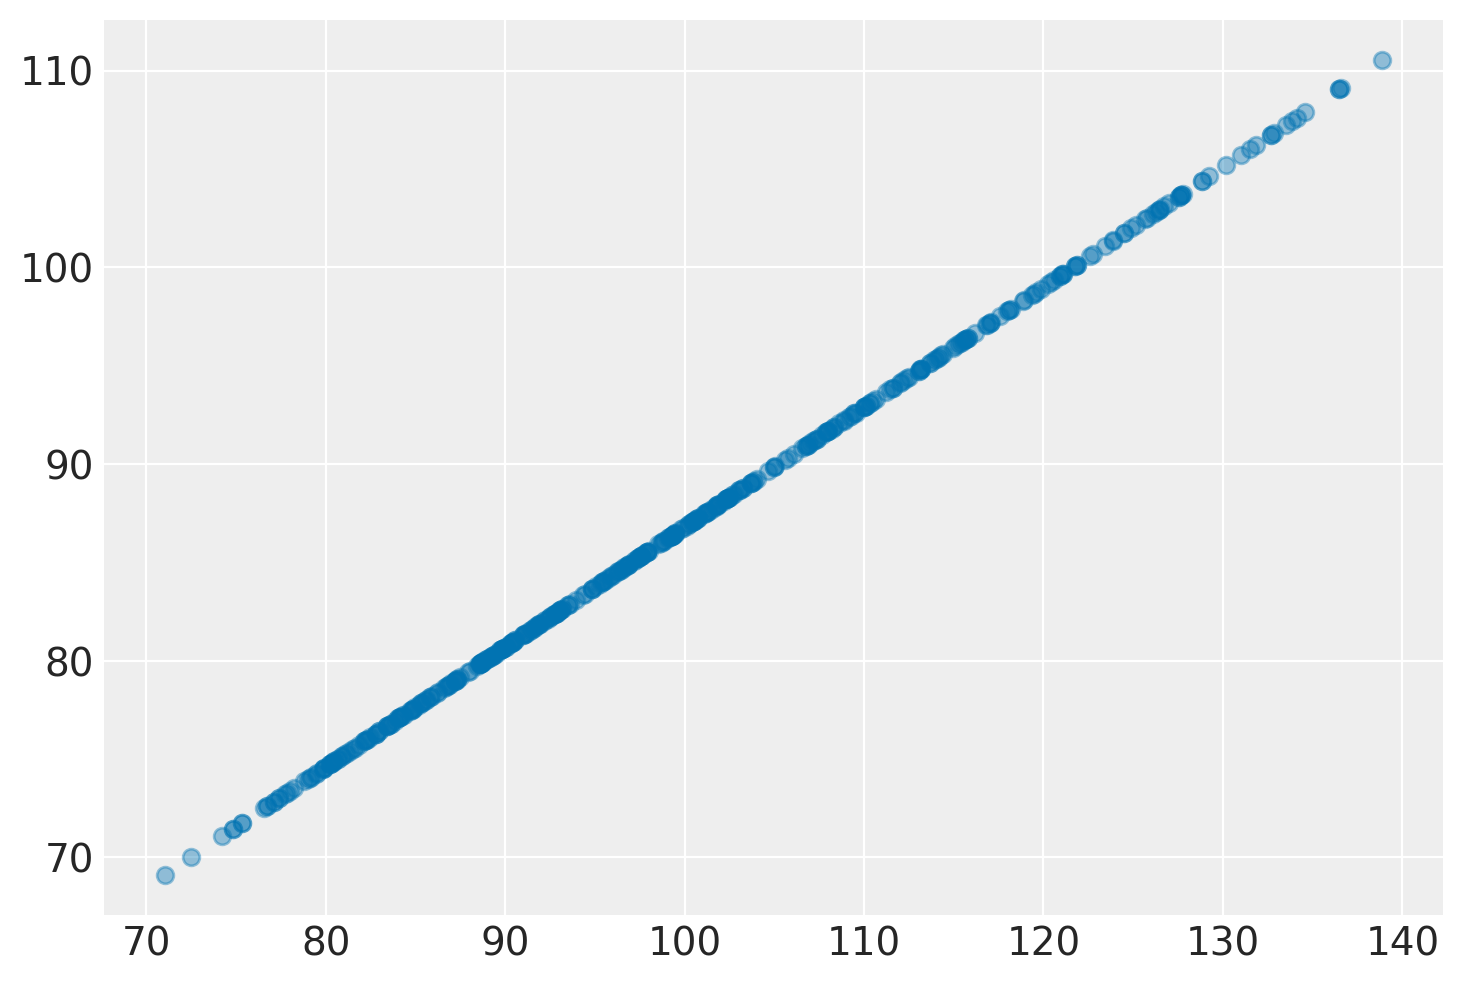

In [14]:
_, ax = plt.subplots()
ax.plot(kidiq["mom_iq"], a + b * kidiq["mom_iq"], "o", alpha=0.4)


Il diagramma precedente presenta ciascun valore $\hat{y}_i = a + b x_i$ in funzione di $x_i$. Si vede che i valori predetti dal modello di regressione sono i punti che stanno sulla retta di regressione.

In precedenza abbiamo detto che il residuo, ovvero la componente di ciascuna osservazione $y_i$ che non viene predetta dal modello di regressione, corrisponde alla *distanza verticale* tra il valore $y_i$ osservato e il valore $\hat{y}_i$ predetto dal modello di regressione:

$$
e_i = y_i - (a + b x_i).
$$

Per fare un esempio numerico, consideriamo il punteggio osservato del QI del primo bambino.

In [15]:
print(kidiq["kid_score"][0])

65


Il QI della madre è

In [16]:
kidiq["mom_iq"][0]

121.11752860260343

Per questo bambino, il valore predetto dal modello di regressione è

In [17]:
a + b * kidiq["mom_iq"][0]


99.67839048842711

L'errore che compiamo per predire il QI del bambino utilizzando il modello di regressione (ovvero, il residuo) è

In [18]:
kidiq["kid_score"][0] - (a + b * kidiq["mom_iq"][0])


-34.67839048842711

Per tutte le osservazioni abbiamo

In [19]:
res = kidiq["kid_score"] - (a + b * kidiq["mom_iq"])
res


0     -34.678390
1      17.691747
2     -11.217173
3      -3.461529
4      32.627697
         ...    
429    16.427159
430    -6.521552
431   -33.661788
432     3.120144
433   -11.461993
Length: 434, dtype: float64

È una proprietà del modello di regressione (calcolato con il metodo dei minimi quadrati) che la somma dei residui sia uguale a zero.

In [20]:
np.sum(res)


-3.183231456205249e-12

Questo significa che ogni valore osservato $y_i$ viene scomposto dal modello di regressione in due componenti distinte. La componente deterministica $\hat{y}_i$, che è predicibile da $x_i$, è data da $\hat{y}_i = a + b x_i$. Il residuo, invece, è dato da $e_i = y_i - \hat{y}_i$. La somma di queste due componenti, ovviamente, riproduce il valore osservato.

In [45]:
pd.DataFrame(
    {
        "kid_score": kidiq["kid_score"],
        "mom_iq": kidiq["mom_iq"],
        "y_hat": a + b * kidiq["mom_iq"],
        "e": kidiq["kid_score"] - (a + b * kidiq["mom_iq"]),
        "y_hat + e": (a + b * kidiq["mom_iq"])
        + (kidiq["kid_score"] - (a + b * kidiq["mom_iq"])),
    }
).head()


,kid_score,mom_iq,y_hat,e,y_hat + e
0,65,121.117529,99.678390,-34.678390,65.0
1,98,89.361882,80.308253,17.691747,98.0
2,85,115.443165,96.217173,-11.217173,85.0
3,83,99.449639,86.461529,-3.461529,83.0
4,115,92.745710,82.372303,32.627697,115.0


### Trasformazione dei dati

In generale, per variabili a livello di scala ad intervalli, l'intercetta del modello di regressione lineare non ha un'interpretazione utile. Questo perché l'intercetta indica il valore atteso di $y$ quando $x = 0$, ma in caso di variabili a scala di intervalli, il valore "0" di $x$ è arbitrario e non corrisponde ad un "assenza" della variabile $x$. Ad esempio, un QI della madre pari a 0 non indica un'assenza di intelligenza, ma solo un valore arbitrario del test usato per misurare il QI. Quindi, sapere il valore medio del QI dei bambini quando il QI della madre è 0 non è di alcun interesse.

Per fornire all'intercetta del modello di regressione un'interpretazione più utile, dobbiamo trasformare le osservazioni di $x$. Per esempio, esprimiamo $x$ come differenza dalla media. Chiamiamo questa nuova variabile $xd$:

In [21]:
kidiq["xd"] = kidiq["mom_iq"] - np.mean(kidiq["mom_iq"])
kidiq


,kid_score,mom_hs,mom_iq,mom_work,mom_age,xd
0,65,1.0,121.117529,4,27,21.117529
1,98,1.0,89.361882,4,25,-10.638118
2,85,1.0,115.443165,4,27,15.443165
3,83,1.0,99.449639,3,25,-0.550361
4,115,1.0,92.745710,4,27,-7.254290
...,...,...,...,...,...,...
429,94,0.0,84.877412,4,21,-15.122588
430,76,1.0,92.990392,4,23,-7.009608
431,50,0.0,94.859708,2,24,-5.140292
432,88,1.0,96.856624,2,21,-3.143376


Se ora usiamo le coppie di osservazioni $(xd_i, y_i)$, il diagramma a dispersione assume la forma seguente.

Text(0, 0.5, 'QI del bambino')

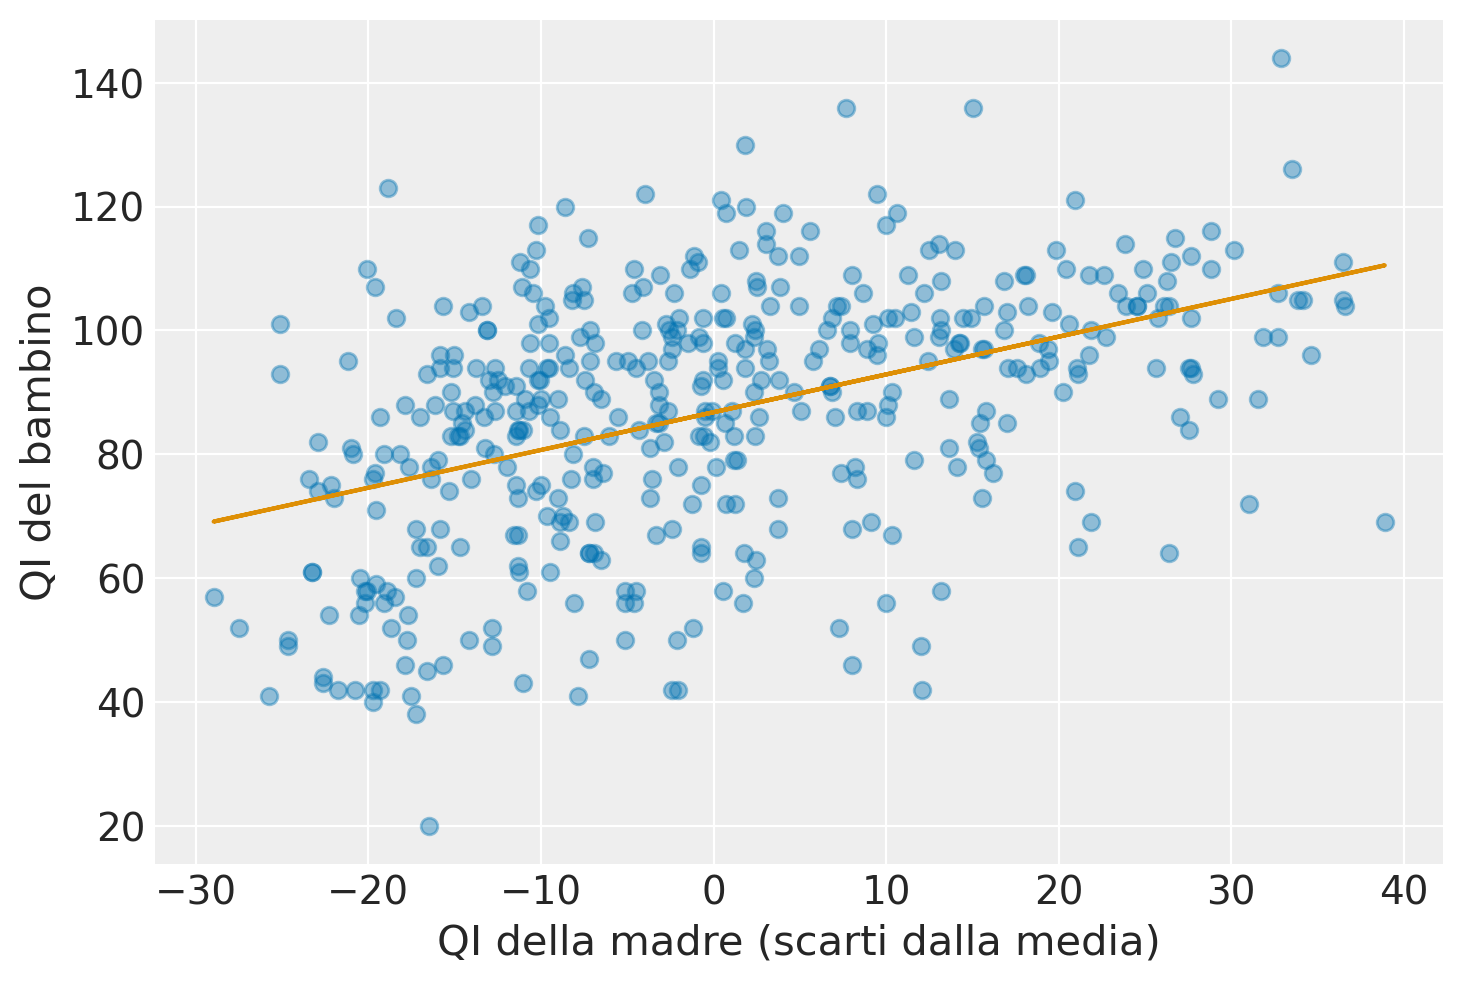

In [22]:
_, ax = plt.subplots()
ax.plot(kidiq["xd"], kidiq["kid_score"], "o", alpha=0.4)
b, a = np.polyfit(kidiq["xd"], kidiq["kid_score"], 1)
plt.plot(kidiq["xd"], a + b * kidiq["xd"])
ax.set_xlabel("QI della madre (scarti dalla media)")
ax.set_ylabel("QI del bambino")


In pratica, abbiamo spostato tutti i punti del grafico lungo l'asse delle $x$, in modo tale che la media dei valori di $x$ sia uguale a 0. Questo non ha cambiato la forma dei punti nel grafico, ma ha solo spostato l'origine dell'asse $x$. La pendenza della linea di regressione tra $x$ e $y$ rimane la stessa, sia per i dati originali che per quelli trasformati. L'unica cosa che cambia è il valore dell'intercetta della linea di regressione, che ora ha un'interpretazione più significativa.

In [23]:
result = stats.linregress(kidiq.xd, kidiq.kid_score)
result.intercept, result.slope


(86.79723502304148, 0.6099745717307852)

L'intercetta rappresenta il punto in cui la retta di regressione incontra l'asse $y$ nel diagramma a dispersione. Nel caso dei dati trasformati, abbiamo spostato la nube di punti lungo l'asse $x$ di una quantità pari a $x - \bar{x}$, ma le relazioni spaziali tra i punti rimangono invariate. Pertanto, la pendenza della retta di regressione non cambia rispetto ai dati non trasformati. Tuttavia, il valore dell'intercetta viene influenzato dalla trasformazione. In particolare, poiché $xd = 0$ corrisponde a $x = \bar{x}$ nei dati grezzi, l'intercetta del modello di regressione lineare calcolata sui dati trasformati corrisponde al valore atteso di $y$ quando $x$ assume il valore medio sulla scala dei dati grezzi. In altre parole, l'intercetta del modello di regressione lineare sui dati trasformati rappresenta il valore atteso del QI dei bambini corrispondente al QI medio delle madri.

### Il metodo dei minimi quadrati

Per calcolare i coefficienti di regressione $a$ e $b$, si deve minimizzare la somma dei quadrati degli scarti tra i valori osservati $y_i$ e quelli previsti dal modello $a + bx_i$ per ogni osservazione $i$. In altre parole, si vuole trovare i valori di $a$ e $b$ che permettono di ottenere la retta di regressione che si avvicina il più possibile ai dati osservati. 

Per calcolare i coefficienti di regressione tramite una simulazione, supponiamo che uno dei due parametri sia noto, ad esempio $a$, così da avere una sola incognita. Creiamo una griglia di valori `b_grid` possibili, ad esempio:

In [24]:
b_grid = np.linspace(0, 1, 1001)


Definiamo una funzione che calcola la somma dei quadrati dei residui $\sum_{i=1}^{n}{(y_i - (a + b x_i))^2}$:

In [25]:
def sse(a, b, x, y):
    return np.sum((y - (a + b * x)) ** 2)


Calcoliamo la somma degli errori quadratici per ciascun possibile valore `b_grid`. Per semplificaer il problema, considerato noto $a = 25.79978$.

In [26]:
a = 25.79978
sse_vals = [sse(a, b, kidiq["mom_iq"], kidiq["kid_score"]) for b in b_grid]


Esaminiamo il risultato ottenuto.


Text(0, 0.5, 'SSE')

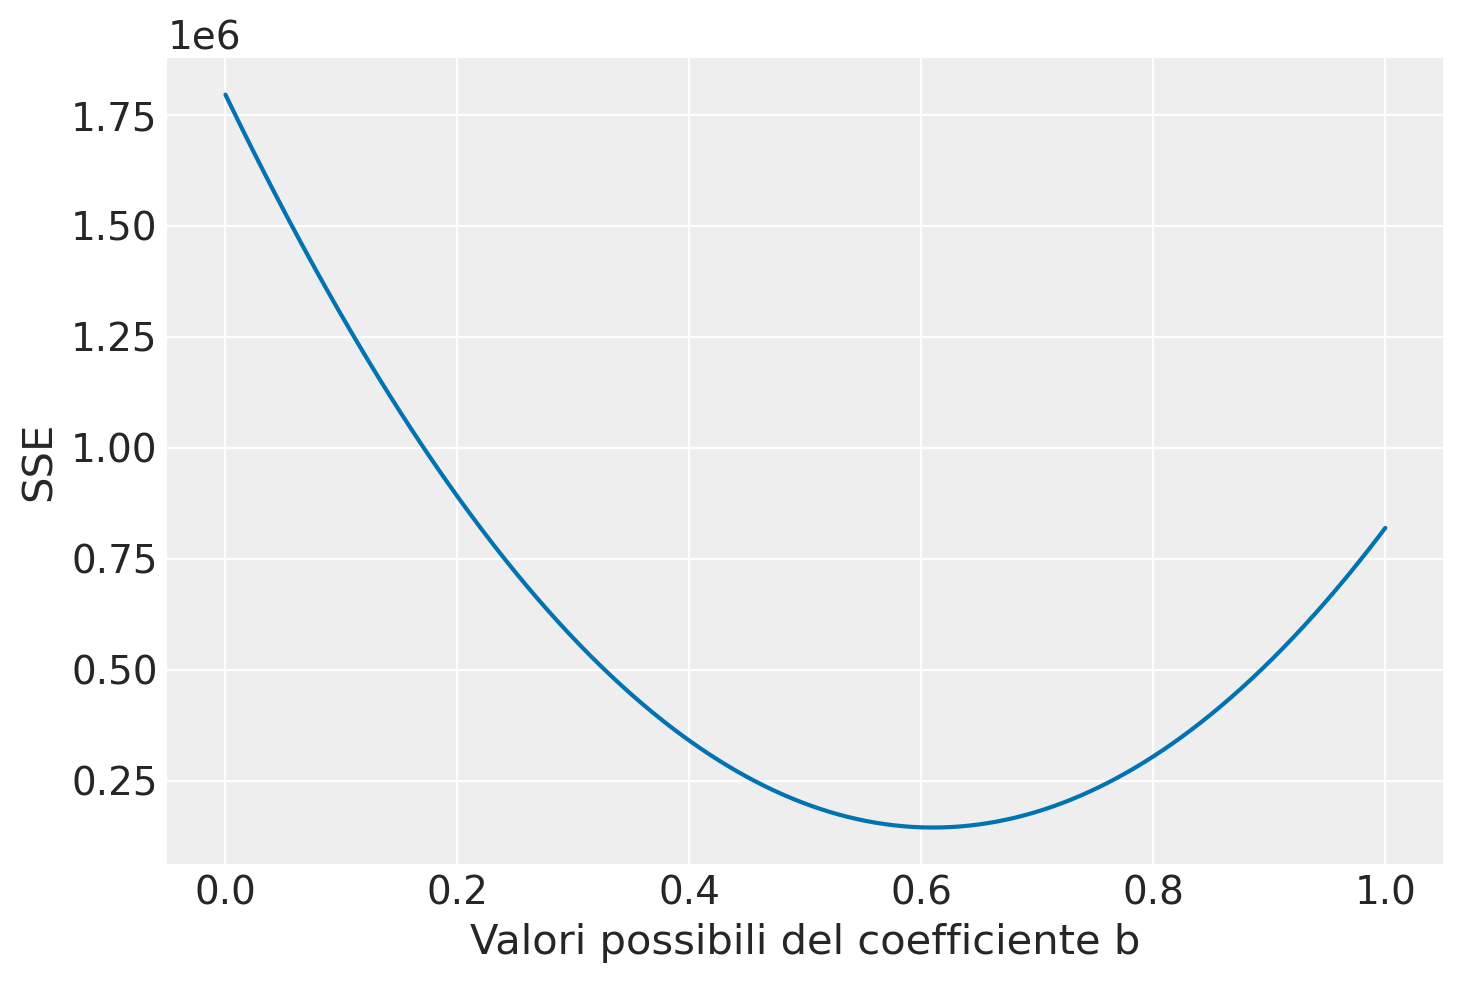

In [27]:
_, ax = plt.subplots()
ax.plot(b_grid, sse_vals)
ax.set_xlabel("Valori possibili del coefficiente b")
ax.set_ylabel("SSE")


Il risultato ottenuto con la simulazione riproduce quello ottenuto per via analitica.


In [28]:
df = pd.DataFrame({"x": b_grid, "y": sse_vals})
df


,x,y
0,0.000,1.795165e+06
1,0.001,1.789756e+06
2,0.002,1.784356e+06
3,0.003,1.778965e+06
4,0.004,1.773583e+06
...,...,...
996,0.996,8.053831e+05
997,0.997,8.088135e+05
998,0.998,8.122527e+05
999,0.999,8.157008e+05


In [29]:
df[df.y == df.y.min()]


,x,y
610,0.61,144137.339359


Abbiamo mostrato un esempio di simulazione per stimare uno dei coefficienti del modello lineare. Tuttavia, una simulazione più complessa, ma computazionalmente più costosa, può essere utilizzata per stimare simultaneamente entrambi i coefficienti del modello lineare. Ciò che abbiamo fatto qui è solo una dimostrazione del concetto di base, ovvero il metodo di minimizzazione dei residui quadrati, che viene utilizzato per stimare i coefficienti del modello lineare.

### L'errore standard della regressione

Il secondo obiettivo del modello di regressione lineare è quello di misurare quanto della variabilità di $y$ possa essere spiegata dalla variabilità di $x$ per ogni osservazione. L'indice di bontà di adattamento del modello viene fornito dalla deviazione standard dei residui, chiamata anche "errore standard della stima", $s_e$. Per calcolare $s_e$, si utilizza una formula che prevede di sommare i quadrati dei residui $e_i$ per ogni osservazione e di dividere per $n-2$, dove $n$ rappresenta la numerosità del campione e $2$ rappresenta il numero di coefficienti stimati nel modello di regressione. L'errore standard della stima $s_e$ possiede la stessa unità di misura di $y$ ed è una stima della deviazione standard dei residui nella popolazione di cui il campione è stato estratto. In altre parole, l'errore standard della stima rappresenta una stima della media dei residui, che indica quanto lontane le previsioni del modello di regressione lineare possono essere dalle osservazioni effettive.

Verifichiamo quanto detto con i dati a disposizione. I residui possono essere trovati nel modo seguente.

In [36]:
e = kidiq.kid_score - (a + b * kidiq.mom_iq)
e[0:10]


0   -34.678390
1    17.691747
2   -11.217173
3    -3.461529
4    32.627697
5     6.382845
6   -41.521041
7     3.864881
8    26.414387
9    11.208068
dtype: float64

Calcoliamo il residuo medio, prendendo il valore assoluto.


In [37]:
np.mean(np.abs(e))


14.468602933080415

L'errore standard della regressione è


In [38]:
np.sqrt(sum(e**2) / (len(e) - 2))


18.26612279229927

Si noti che i due valori non sono uguali, ma hanno lo stesso ordine di grandezza.

## Indice di determinazione

Un importante risultato dell'analisi di regressione riguarda la scomposizione della varianza della variabile dipendente $y$ in due componenti: la varianza spiegata dal modello e la varianza residua. Questa scomposizione è descritta mediante l'indice di determinazione $R^2$, che fornisce una misura della bontà di adattamento del modello ai dati del campione. 

Per una generica osservazione $x_i, y_i$, la deviazione di $y_i$ rispetto alla media $\bar{y}$ può essere espressa come la somma di due componenti: il residuo $e_i=y_i- \hat{y}_i$ e lo scarto di $\hat{y}_i$ rispetto alla media $\bar{y}$:

$$
y_i - \bar{y} = (y_i- \hat{y}_i) + (\hat{y}_i - \bar{y}) = e_i + (\hat{y}_i - \bar{y}).
$$

La varianza totale di $y$ può quindi essere scritta come:

$$
\sum_{i=1}^{n}(y_i - \bar{y})^2 = \sum_{i=1}^{n}(e_i + (\hat{y}_i - \bar{y}))^2.
$$

Sviluppando il quadrato e sommando, si ottiene:

$$
\sum_{i=1}^{n}(y_i - \bar{y})^2 = \sum_{i=1}^{n}(y_i - \hat{y}_i)^2 + \sum_{i=1}^{n}(\hat{y}_i - \bar{y})^2.
$$

Il primo termine rappresenta la varianza residua, mentre il secondo termine rappresenta la varianza spiegata dal modello. L'indice di determinazione $R^2$ è definito come il rapporto tra la varianza spiegata e la varianza totale:

$$
R^2 = \frac{\sum_{i=1}^{n}(\hat{y}_i - \bar{y})^2}{\sum_{i=1}^{n}(y_i - \bar{y})^2}.
$$

Questo indice varia tra 0 e 1 e indica la frazione di varianza totale di $y$ spiegata dal modello di regressione lineare. Un valore alto di $R^2$ indica che il modello di regressione lineare si adatta bene ai dati, in quanto una grande parte della varianza di $y$ è spiegata dalla variabile indipendente $x$.

Per l'esempio in discussione abbiamo quanto segue. La devianza totale è

In [39]:
dev_t = np.sum((kidiq.kid_score - np.mean(kidiq.kid_score)) ** 2)
dev_t


180386.15668202768

La devianza spiegata è

In [40]:
dev_r = np.sum(((a + b * kidiq.mom_iq) - np.mean(kidiq.kid_score)) ** 2)
dev_r


36248.820197058216

L'indice di determinazione è


In [41]:
R2 = dev_r / dev_t
round(R2, 3)


0.201

Verifichiamo.

In [42]:
X = sm.add_constant(kidiq["mom_iq"])
mod = sm.OLS(kidiq["kid_score"], X)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              kid_score   R-squared:                       0.201
Model:                            OLS   Adj. R-squared:                  0.199
Method:                 Least Squares   F-statistic:                     108.6
Date:                Fri, 05 May 2023   Prob (F-statistic):           7.66e-23
Time:                        09:55:03   Log-Likelihood:                -1875.6
No. Observations:                 434   AIC:                             3755.
Df Residuals:                     432   BIC:                             3763.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         25.7998      5.917      4.360      0.0

Il risultato ottenuto si può interpretare dicendo che circa il 20% della variabilità dei punteggi del QI dei bambini può essere predetto conoscendo il QI delle madri.

### Inferenza sul modello di regressione

Il paragrafo precedente discute l'approccio "classico" al modello di regressione lineare, che si basa sulle stime dei minimi quadrati. Questo approccio non tiene conto delle distribuzioni a priori dei parametri $\alpha$ e $\beta$. Se imponiamo distribuzioni a priori uniformi (non informative) sui parametri, le stime di massima verosimiglianza coincidono con il massimo a posteriori bayesiano. Tuttavia, in un contesto bayesiano, è possibile imporre distribuzioni a priori debolmente o informativamente. In questo caso, la scelta della distribuzione a priori ha un effetto sulla regolarizzazione dei dati.

Nell'approccio frequentista, l'inferenza viene effettuata calcolando la distribuzione campionaria dei parametri e gli intervalli di fiducia per i parametri. Ad esempio, se si vuole determinare se la pendenza della retta di regressione è maggiore di zero, si calcola l'intervallo di fiducia al 95% per il parametro $\beta$. Se l'intervallo non include lo zero e se il limite inferiore dell'intervallo è maggiore di zero, si conclude che c'è evidenza di un'associazione lineare positiva tra $x$ e $y$ con un grado di confidenza del 95%.

In un'ottica bayesiana, l'intervallo di credibilità al 95% per il parametro $\beta$ può essere calcolato. Se usiamo una distribuzione a priori uniforme, gli intervalli di credibilità e di fiducia sono identici. Tuttavia, se usiamo una distribuzione a priori debolmente o informativamente, i due intervalli possono differire. Solitamente si usa una distribuzione a priori debolmente informativa centrata sullo zero, che ha l'effetto di regolarizzare i dati. Il prossimo capitolo spiegherà come effettuare l'inferenza sui coefficienti del modello di regressione lineare in un contesto bayesiano.

## Commenti e considerazioni finali

Il modello lineare bivariato è uno strumento fondamentale per analizzare la relazione tra due variabili. Non solo ci permette di capire se esiste una correlazione tra le due variabili, ma ci permette anche di determinare il grado di intensità di tale correlazione e di fare previsioni sull'andamento futuro.

In pratica, il modello lineare ci consente di rispondere a domande del tipo: se il valore della variabile indipendente aumenta di una certa quantità, di quanto aumenterà il valore della variabile dipendente? Oppure, se il valore della variabile indipendente diminuisce, di quanto diminuirà il valore della variabile dipendente?

Questi sono solo alcuni esempi di come il modello lineare bivariato possa essere utilizzato per fare previsioni. La bellezza di questo modello sta nella sua semplicità: si tratta di una formula matematica che ci permette di descrivere la relazione tra le due variabili in modo chiaro e preciso. Inoltre, il modello lineare può essere utilizzato anche in contesti più complessi, ad esempio quando ci sono più variabili indipendenti che influenzano la variabile dipendente.

Insomma, il modello lineare bivariato è uno strumento fondamentale per analizzare e comprendere le relazioni tra le variabili, e ci permette di fare previsioni utili per prendere decisioni informate e ottimizzare i nostri risultati.

## Watermark

In [46]:
%load_ext watermark
%watermark -n -u -v -iv 

Last updated: Fri May 05 2023

Python implementation: CPython
Python version       : 3.11.3
IPython version      : 8.13.1

pandas     : 2.0.1
statsmodels: 0.13.5
arviz      : 0.15.1
numpy      : 1.23.5
matplotlib : 3.7.1
scipy      : 1.10.1
seaborn    : 0.12.2

